# Core Imports

In [10]:
# Custom Imports
from polysaccharide import general
from polysaccharide.general import optional_in_place
from polysaccharide.extratypes import ResidueSmarts

from polysaccharide.molutils import reactions
from polysaccharide.molutils.rdmol.rdtypes import *
from polysaccharide.molutils.rdmol import rdcompare, rdconvert, rdkdraw, rdcompare, rdprops, rdbond, rdlabels

from polysaccharide.polymer import monomer
from polysaccharide.polymer.monomer import MonomerInfo

# Generic Imports
import re
from functools import partial, cached_property
from collections import defaultdict
from itertools import combinations, chain
from ast import literal_eval

# Numeric imports
import pandas as pd
import numpy as np

# File I/O
from pathlib import Path
import csv, json, openpyxl

# Typing and Subclassing
from typing import Any, Callable, ClassVar, Generator, Iterable, Optional, Union
from dataclasses import dataclass, field
from abc import ABC, abstractmethod, abstractproperty
from openmm.unit import Unit, Quantity

# Cheminformatics
from rdkit import Chem
from rdkit.Chem import rdChemReactions

# Static Paths
RAW_DATA_PATH = Path('raw_monomer_data')
PROC_DATA_PATH = Path('processed_monomer_data')
RXN_FILES_PATH = Path('rxn_smarts')

# Preprocessing and cleaning up NREL Urethane data

## Loading and inspecting raw data

In [2]:
p = RAW_DATA_PATH / 'nipu_urethanes.xlsx'
raw_table = pd.read_excel(p) # load from .xlsx file
raw_table['Monomers'] = raw_table['Monomers'].apply(literal_eval) # convert string of tuples into proper tuples

nipus     = raw_table[raw_table['Chemistry'] == 'NIPU'    ]
urethanes = raw_table[raw_table['Chemistry'] == 'urethane']

nipus_mono     = nipus['Monomers'].reset_index(drop=True) # extract monomers and renumber subset in-order
urethanes_mono = urethanes['Monomers'].reset_index(drop=True) # extract monomers and renumber subset in-order

In [3]:
rdkdraw.set_rdkdraw_size(300, 3/2)
# targ_mono = nipus_mono
targ_mono = {}

for i, monos in targ_mono.items():
    try:
        mono1, mono2 = monos
        display(Chem.MolFromSmiles(mono1))
        
        print('='*50)
    except ValueError:
        print(f'Row {i} failed')

## Classify each monomer pair by respective reactive functional group

In [11]:
with (RXN_FILES_PATH / 'fn_group_smarts.json').open('r') as fn_group_file:
    fn_group_SMARTS = json.load(fn_group_file)
    fn_groups = {
        group_name : Chem.MolFromSmarts(SMARTS)
            for group_name, SMARTS in fn_group_SMARTS.items()
    }

reaction_pairs = {
    'NIPU' : ('cyclocarbonate', 'amine'),
    'urethane' : ('isocyanate', 'hydroxyl')
}

all_results = []
digroup_only_results = []
for i, (chemistry, monomer_pair) in raw_table.iterrows():
    monomer_entry = {
        'Chemistry' : chemistry
    }

    too_many_sites = False
    for SMILES in monomer_pair:
        rdmol = Chem.MolFromSmiles(SMILES)
        rdmol = Chem.AddHs(rdmol)

        for group_name, fn_group in fn_groups.items():
            matches = rdmol.GetSubstructMatches(fn_group)
            if matches and (group_name in reaction_pairs[chemistry]):
                monomer_entry[group_name] = Chem.MolToSmarts(rdmol)
            too_many_sites |= (len(matches) > 2) # OR with previous result; single true will make result true
        
    all_results.append(monomer_entry)
    if not too_many_sites:        
        digroup_only_results.append(monomer_entry)

## Save to csv files for future reference

In [ ]:

all_table = pd.DataFrame.from_records(all_results)
digroup_only_table = pd.DataFrame.from_records(digroup_only_results)

all_table.to_csv(PROC_DATA_PATH / 'clean_smarts_all.csv')
digroup_only_table.to_csv(PROC_DATA_PATH / 'clean_smarts_digroup.csv')

In [14]:
pd.read_csv(PROC_DATA_PATH / 'clean_smarts_digroup.csv', index_col=[0])

,Chemistry,amine,cyclocarbonate,hydroxyl,isocyanate
0,NIPU,[#7](-[#6](-[#6](-[#6](-[#6](-[#7](-[H])-[H])(...,[#6](-[#6](-[#6](-[#6](-[#6](-[#6](-[#6](-[#6]...,NaN,NaN
1,NIPU,[#7](-[#6](-[#6](-[#6](-[#7](-[#6](-[#6](-[#6]...,[#6](-[#6](-[#6](-[#6](-[#6](-[#6](-[#6](-[#6]...,NaN,NaN
2,NIPU,[#6](-[#6](-[#6](-[#6](-[#6](-[#6](-[#7](-[#6]...,[#8]=[#6]1-[#8]-[#6](-[#6](-[#6](-[#8]-[#6](-[...,NaN,NaN
3,NIPU,[#6](-[#6](-[#6](-[#6](-[#6](-[#6](-[#6](-[#6]...,[#8]=[#6]1-[#8]-[#6](-[#6](-[#6](-[#8]-[#6](-[...,NaN,NaN
4,NIPU,[#7](-[#6](-[#6](-[#8]-[#6](-[#6](-[#8]-[#6](-...,[#6](-[#6](-[#6](-[#6](-[#6](-[#6](-[#6](-[#6]...,NaN,NaN
...,...,...,...,...,...
71,urethane,NaN,NaN,[#8](-[#6](-[#6](-[#6](-[#6](-[#6](-[#6](-[#8]...,[#8]=[#6]=[#7]-[#6](-[#6](-[#6](-[#6](-[#6](-[...
72,urethane,NaN,NaN,[#8](-[#6](-[#6](-[#8]-[H])(-[H])-[H])(-[H])-[...,[#8]=[#6]=[#7]-[#6]1:[#6](:[#6](:[#6](-[#6](-[...
73,urethane,NaN,NaN,[#8](-[#6](-[#6](-[#6](-[#6](-[#8]-[H])(-[H])-...,[#8]=[#6]=[#7]-[#6](-[#6](-[#6](-[#6](-[#6](-[...
74,urethane,NaN,NaN,[#8](-[#6](-[#6](-[#8]-[H])(-[H])-[H])(-[H])-[...,[#8]=[#6]=[#7]-[#6](-[#6](-[#6](-[#6](-[#6](-[...


## Testing reaction replacement rules

## Loading reaction mechanisms

In [5]:
# from SMARTS
with (RXN_FILES_PATH / 'rxn_smarts.json').open('r') as rxn_file:
    rxn_smarts = json.load(rxn_file)
    rxns = {
        chemistry : reactions.AnnotatedReaction.from_smarts(rxn_SMARTS)
            for chemistry, rxn_SMARTS in rxn_smarts.items()
    }

In [8]:
# from files
rxns = {
    chemistry : reactions.AnnotatedReaction.from_rxnfile(RXN_FILES_PATH / f'{chemistry}.rxn')
        for chemistry in reaction_pairs.keys()
}


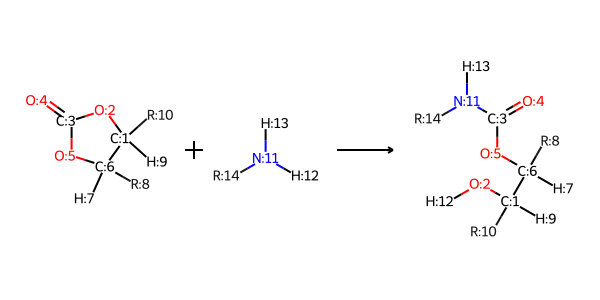

In [9]:
rxns['NIPU']

## Polymerizing and generating fragments

In [ ]:
# for j, sample in digroup_only_table.tail(2).iterrows():
# for j, sample in digroup_only_table.head(5).iterrows():

rdkdraw.set_rdkdraw_size(400, 3/2)
for sample in (digroup_only_table.iloc[2], digroup_only_table.iloc[-2]):
    # look up reactive groups and pathway by chemistry
    chemistry = sample['Chemistry']
    rxn_grp_names = reaction_pairs[chemistry]
    rxn = rxns[chemistry]

    # read reactant monomers from digroup_only_table
    reactants = []
    for i, group_name in enumerate(rxn_grp_names):
        reactant = Chem.MolFromSmarts(sample[group_name])
        for atom in reactant.GetAtoms():
            atom.SetProp('reactant_group', group_name)
        
        reactants.append(reactant)
    mono_info = MonomerInfo()

    # first round of polymerization (initiation)
    reactor_1 = reactions.PolymerizationReactor(rxn, reactants=reactants)
    reactor_1.react()
    display(reactor_1.polymerized_fragments(separate=False))

    mono_info.monomers[f'{"_".join(rxn_grp_names)}_DIMER'] = Chem.MolToSmarts(rdlabels.clear_atom_map_nums(reactor_1.product, in_place=False))
    for assoc_group_name, rdfragment in zip(rxn_grp_names, reactor_1.polymerized_fragments(separate=True)):
        rdlabels.clear_atom_isotopes(rdfragment, in_place=True)
        mono_info.monomers[f'{assoc_group_name}_TERM'] = Chem.MolToSmarts(rdfragment)

    # second round of polymerization (propagation)
    reactor_2 = reactions.PolymerizationReactor(rxn, reactor_1.polymerized_fragments(separate=True))
    reactor_2.react()
    display(reactor_2.polymerized_fragments(separate=False))

    for assoc_group_name, rdfragment in zip(rxn_grp_names, reactor_2.polymerized_fragments(separate=True)):
        rdlabels.clear_atom_isotopes(rdfragment, in_place=True)
        mono_info.monomers[f'{assoc_group_name}_MID'] = Chem.MolToSmarts(rdfragment)

    # add serial map numbers to monomer fragment SMARTS
    for monomer_tag, smarts in mono_info.monomers.items():
        monomer = Chem.MolFromSmarts(smarts)
        rdlabels.assign_ordered_atom_map_nums(monomer, in_place=True)
        mono_info.monomers[monomer_tag] = Chem.MolToSmarts(monomer)

mono_info